In [ ]:
!pip install pycryptodomex
!pip install scikit-image




In [ ]:
#importing required libraries
import cv2
import numpy as np
import types
from Crypto.Cipher import AES
from google.colab.patches import cv2_imshow

In [ ]:
#getting the cover image and the data to be embedded
image_name = input("Enter image name(with extension): ") 
image = cv2.imread(image_name)
data = input("Enter data to be encoded : ") 
if (len(data) == 0): 
  raise ValueError('Data is empty')

Enter image name(with extension): lena.png
Enter data to be encoded : tamil


The shape of the image is:  (512, 512, 3)
The original image is as shown below: 


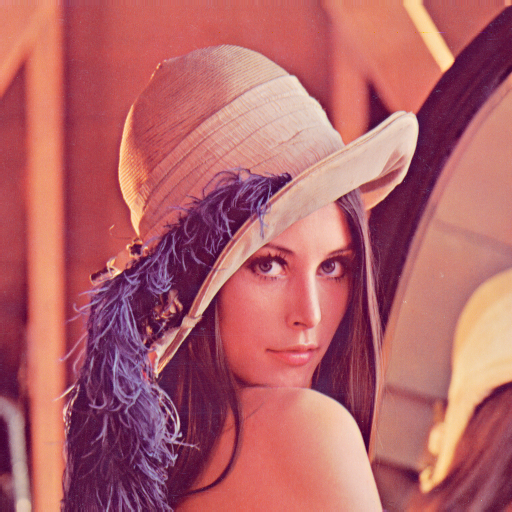

In [ ]:
#details of the image
print("The shape of the image is: ",image.shape) #check the shape of image to calculate the number of bytes in it
print("The original image is as shown below: ")
resized_image = cv2.resize(image, (500, 500)) #resize the image as per your requirement
cv2_imshow(image)

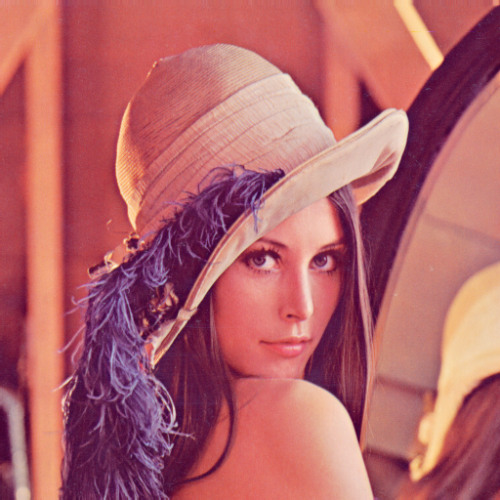

In [ ]:
#resizing image
cv2_imshow(resized_image)

In [ ]:

# AES encryption 
from Crypto.Random import get_random_bytes
from Cryptodome.Cipher import AES
import hashlib
from base64 import b64encode
def encrypt(plain_text, password):
    global encryption_dic
    # generate a random salt
    salt = get_random_bytes(AES.block_size)

    # use the Scrypt KDF to get a private key from the password
    private_key = hashlib.scrypt(
        password.encode(), salt=salt, n=2**14, r=8, p=1, dklen=32)

    # create cipher config
    cipher_config = AES.new(private_key, AES.MODE_GCM)

    # return a dictionary with the encrypted text
    cipher_text, tag = cipher_config.encrypt_and_digest(bytes(plain_text, 'utf-8'))
    encryption_dic= {
        'cipher_text': b64encode(cipher_text).decode('utf-8'),
        'salt': b64encode(salt).decode('utf-8'),
        'nonce': b64encode(cipher_config.nonce).decode('utf-8'),
        'tag': b64encode(tag).decode('utf-8')
    }
    return encryption_dic



In [ ]:
#Using AES encryption
key = input("Enter a Cryptographic key:")
encrypt(data,key)


Enter a Cryptographic key:venkat


{'cipher_text': '5gO3WiE=',
 'nonce': 'Du54q/x0cobflOcPvxgdxg==',
 'salt': 'sgWDYev3f5Km7etterwIYw==',
 'tag': 'n9lsiMG/ohU5IiIx6KRRvg=='}

In [ ]:
#for converting the message into binary format
def messageToBinary(message):
  if type(message) == str:
    return ''.join([ format(ord(i), "08b") for i in message ])
  elif type(message) == bytes or type(message) == np.ndarray:
    return [ format(i, "08b") for i in message ]
  elif type(message) == int or type(message) == np.uint8:
    return format(message, "08b")
  else:
    raise TypeError("Input type not supported")

In [ ]:
#checking if the above mentioned function works
bin_msg=messageToBinary(encryption_dic["cipher_text"])

In [ ]:
#Using Zlib module for lossless compression of the data
import zlib
import binascii
compressed_data = zlib.compress(encryption_dic["cipher_text"].encode("utf-8"),-1)
print(compressed_data)

b'x\x9c3M\xf77\x0e\xcft\xb5\x05\x00\n\xb8\x02a'


In [ ]:
msg_to_bin = messageToBinary(compressed_data)

In [ ]:
def hideData(image, secret_message):

  # calculate the maximum bytes to encode
  n_bytes = image.shape[0] * image.shape[1] * 3 // 8
  print("Maximum bytes to encode:", n_bytes)

  #Check if the number of bytes to encode is less than the maximum bytes in the image
  if len(secret_message) > n_bytes:
      raise ValueError("Error encountered insufficient bytes, need bigger image or less data !!")
  
  secret_message += "#####" # you can use any string as the delimeter

  data_index = 0
  # convert input data to binary format using messageToBinary() fucntion
  binary_secret_msg = messageToBinary(secret_message)

  data_len = len(binary_secret_msg) #Find the length of data that needs to be hidden
  for values in image:
      for pixel in values:
          # convert RGB values to binary format
          r, g, b = messageToBinary(pixel)
          # modify the least significant bit only if there is still data to store
          if data_index < data_len:
              # hide the data into least significant bit of red pixel
              pixel[0] = int(r[:-1] + binary_secret_msg[data_index], 2)
              data_index += 1
          if data_index < data_len:
              # hide the data into least significant bit of green pixel
              pixel[1] = int(g[:-1] + binary_secret_msg[data_index], 2)
              data_index += 1
          if data_index < data_len:
              # hide the data into least significant bit of  blue pixel
              pixel[2] = int(b[:-1] + binary_secret_msg[data_index], 2)
              data_index += 1
          # if data is encoded, just break out of the loop
          if data_index >= data_len:
              break

  return image




In [ ]:
def showData(image):

  binary_data = ""
  for values in image:
      for pixel in values:
          r, g, b = messageToBinary(pixel) #convert the red,green and blue values into binary format
          binary_data += r[-1] #extracting data from the least significant bit of red pixel
          binary_data += g[-1] #extracting data from the least significant bit of red pixel
          binary_data += b[-1] #extracting data from the least significant bit of red pixel
  # split by 8-bits
  all_bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
  # convert from bits to characters
  decoded_data = ""
  for byte in all_bytes:
      decoded_data += chr(int(byte, 2))
      if decoded_data[-5:] == "#####": #check if we have reached the delimeter which is "#####"
          break
  #print(decoded_data)
  return decoded_data[:-5] #remove the delimeter to show the original hidden message



In [ ]:
#encoding data into image
filename = input("Enter the name of new encoded image(with extension): ")
encoded_image = hideData(image, bin_msg) # call the hideData function to hide the secret message into the selected image
cv2.imwrite(filename, encoded_image)


Enter the name of new encoded image(with extension): lena1.png
Maximum bytes to encode: 98304


True

In [ ]:
def decode_text():
  # read the image that contains the hidden image
  image_name = input("Enter the name of the steganographed image that you want to decode (with extension) :") 
  image = cv2.imread(image_name) #read the image using cv2.imread() 
  text = showData(image)
  return text

decode_text()

Enter the name of the steganographed image that you want to decode (with extension) :lena1.png


'0011010101100111010011110011001101010111011010010100010100111101'

In [ ]:
#Decrypting AES algorithm
from base64 import b64decode
def decrypt(enc_dict, password):
    # decode the dictionary entries from base64
    salt = b64decode(enc_dict['salt'])
    cipher_text = b64decode(enc_dict['cipher_text'])
    nonce = b64decode(enc_dict['nonce'])
    tag = b64decode(enc_dict['tag'])
    

    # generate the private key from the password and salt
    private_key = hashlib.scrypt(
        password.encode(), salt=salt, n=2**14, r=8, p=1, dklen=32)

    # create the cipher config
    cipher = AES.new(private_key, AES.MODE_GCM, nonce=nonce)

    # decrypt the cipher text
    decrypted = cipher.decrypt_and_verify(cipher_text, tag)

    return decrypted.decode("utf-8")

In [ ]:
decrypt(encryption_dic,key)

'tamil'

In [ ]:
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB)
	# setup the figure
	fig = plt.figure(title)
	plt.suptitle("MSE: %f, SSIM: %f" % (m, s))
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
	# show the images
	plt.show()

In [ ]:
#converting to greyscale
image1 = cv2.imread("lena.png")
image2 = cv2.imread("lena1.png")
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


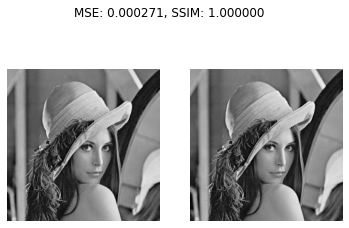

In [ ]:
#comparing the two images
image3 = cv2.imread("dhoni(1).png")
compare_images(image1,image2,"Cover image vs Stego image")



In [ ]:
#checking psnr
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
def main(): 
     original = cv2.imread("lena.png") 
     compressed = cv2.imread("lena1.png", 1) 
     value = PSNR(original, compressed) 
     print(f"PSNR value is {value} dB") 
       
if __name__ == "__main__": 
    main()

PSNR value is 82.88785789049477 dB


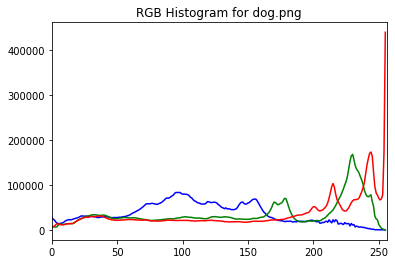

KeyboardInterrupt: ignored

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('dog.png', -1)
plt.show('dog.png',img)

color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('RGB Histogram for dog.png')
plt.show()

while True:
    k = cv2.waitKey(0) & 0xFF     
    if k == 27: break             # ESC key to exit 
cv2.destroyAllWindows()